In [2]:
import pandas as pd
import kagglehub
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score




In [3]:

path = kagglehub.dataset_download("uciml/mushroom-classification")
print("Path to dataset files:", path)
df = pd.read_csv(path + "/mushrooms.csv")

Path to dataset files: C:\Users\ICOSTARE\.cache\kagglehub\datasets\uciml\mushroom-classification\versions\1
Path to dataset files: C:\Users\ICOSTARE\.cache\kagglehub\datasets\uciml\mushroom-classification\versions\1


# Detalles del dataset

**Attribute Information:** (classes: edible=e, poisonous=p)

- **cap-shape:** bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
- **cap-surface:** fibrous=f, grooves=g, scaly=y, smooth=s
- **cap-color:** brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
- **bruises:** bruises=t, no=f
- **odor:** almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
- **gill-attachment:** attached=a, descending=d, free=f, notched=n
- **gill-spacing:** close=c, crowded=w, distant=d
- **gill-size:** broad=b, narrow=n
- **gill-color:** black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
- **stalk-shape:** enlarging=e, tapering=t
- **stalk-root:** bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
- **stalk-surface-above-ring:** fibrous=f, scaly=y, silky=k, smooth=s
- **stalk-surface-below-ring:** fibrous=f, scaly=y, silky=k, smooth=s
- **stalk-color-above-ring:** brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
- **stalk-color-below-ring:** brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
- **veil-type:** partial=p, universal=u
- **veil-color:** brown=n, orange=o, white=w, yellow=y
- **ring-number:** none=n, one=o, two=t
- **ring-type:** cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
- **spore-print-color:** black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
- **population:** abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
- **habitat:** grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

In [4]:
#Buscar presencia de nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [5]:
#Ajustar nombre de columnas
df.columns = df.columns.str.replace('-', '_')
#Buscar valores faltantes con simbolo ?
df.where(df == '?').count()

class                          0
cap_shape                      0
cap_surface                    0
cap_color                      0
bruises                        0
odor                           0
gill_attachment                0
gill_spacing                   0
gill_size                      0
gill_color                     0
stalk_shape                    0
stalk_root                  2480
stalk_surface_above_ring       0
stalk_surface_below_ring       0
stalk_color_above_ring         0
stalk_color_below_ring         0
veil_type                      0
veil_color                     0
ring_number                    0
ring_type                      0
spore_print_color              0
population                     0
habitat                        0
dtype: int64

In [6]:
#Reemplazar ? por NaN
df = df.replace('?', np.nan)

In [7]:
#Balance de clases
df['class'].value_counts(normalize=True)

class
e    0.517971
p    0.482029
Name: proportion, dtype: float64

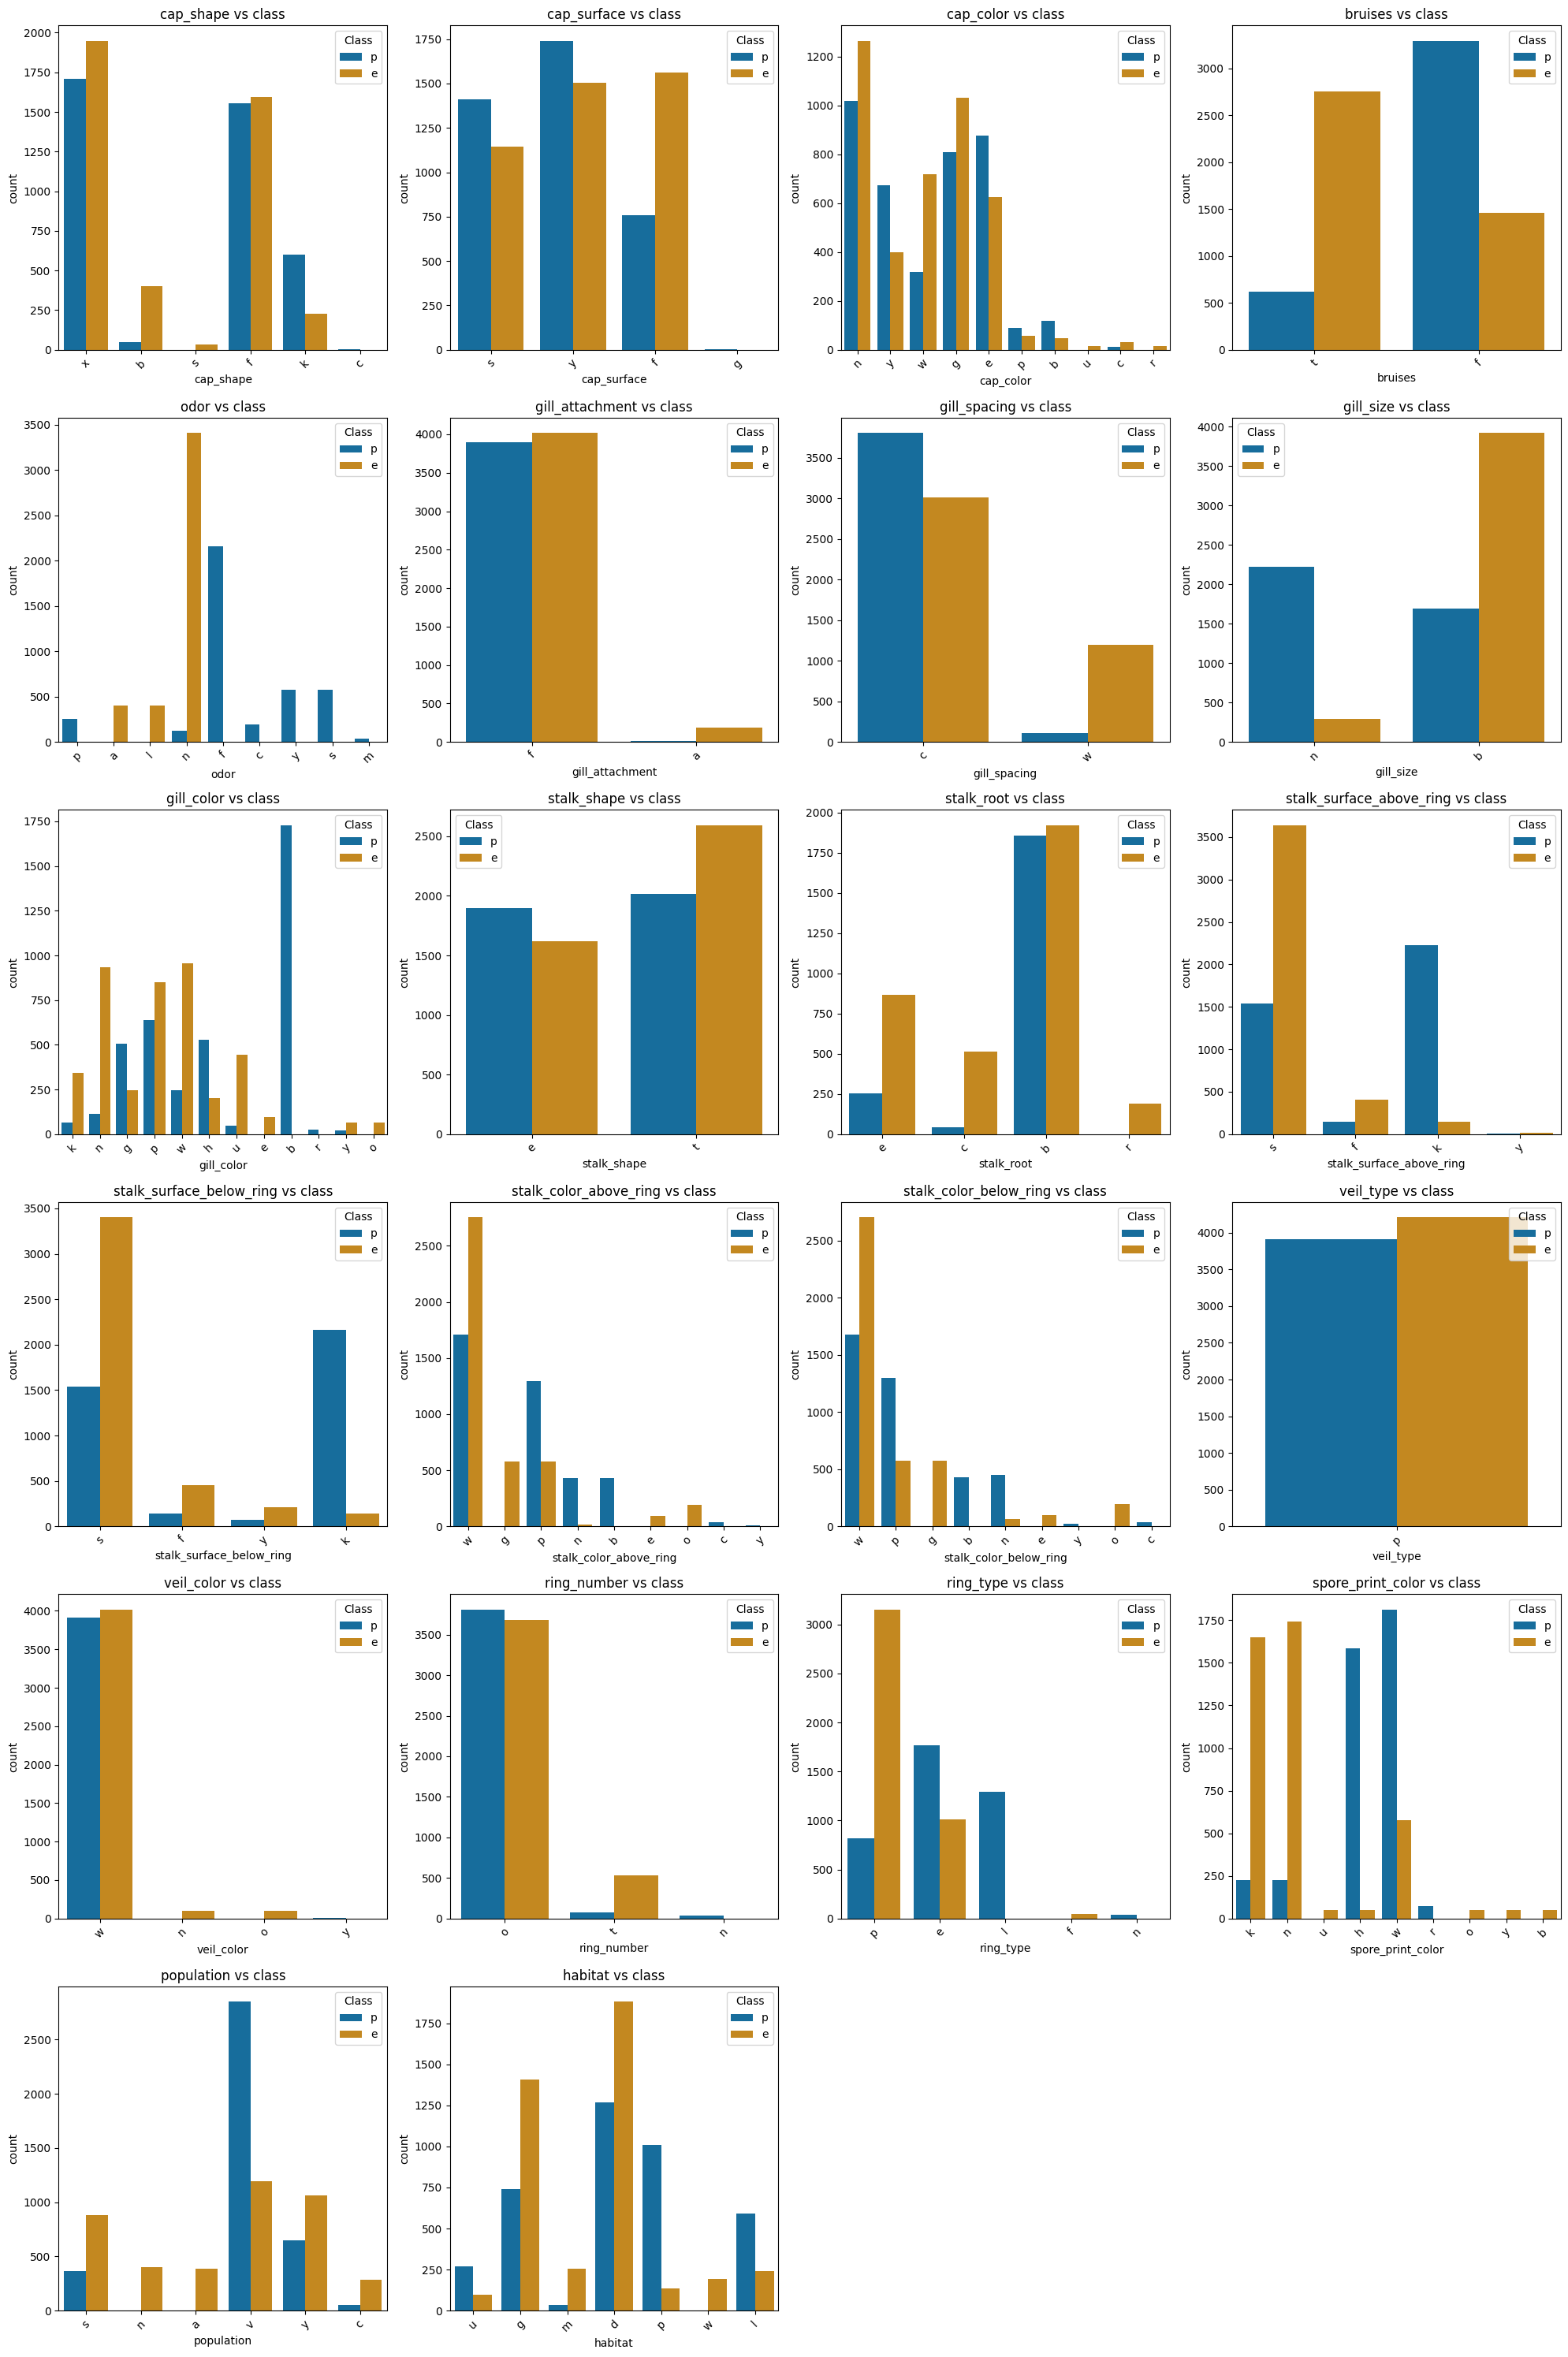

In [8]:
#Buscamos a simple vista features que separan las clases o que no aportan informacion.
#Se encuentran 3 features que separan las clases completamente: odor, gill_color, spore_print_color
#Tambien se observa que veil_type tiene un solo valor, por lo que no aporta informacion
feature_cols = [col for col in df.columns if col != 'class']
n_cols = 4  
n_rows = (len(feature_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.countplot(x=col, data=df, hue='class', palette='colorblind', ax=axes[i])
    axes[i].set_title(f'{col} vs class')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Class')

# Ocultar subplots vacíos si los hay
for j in range(len(feature_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

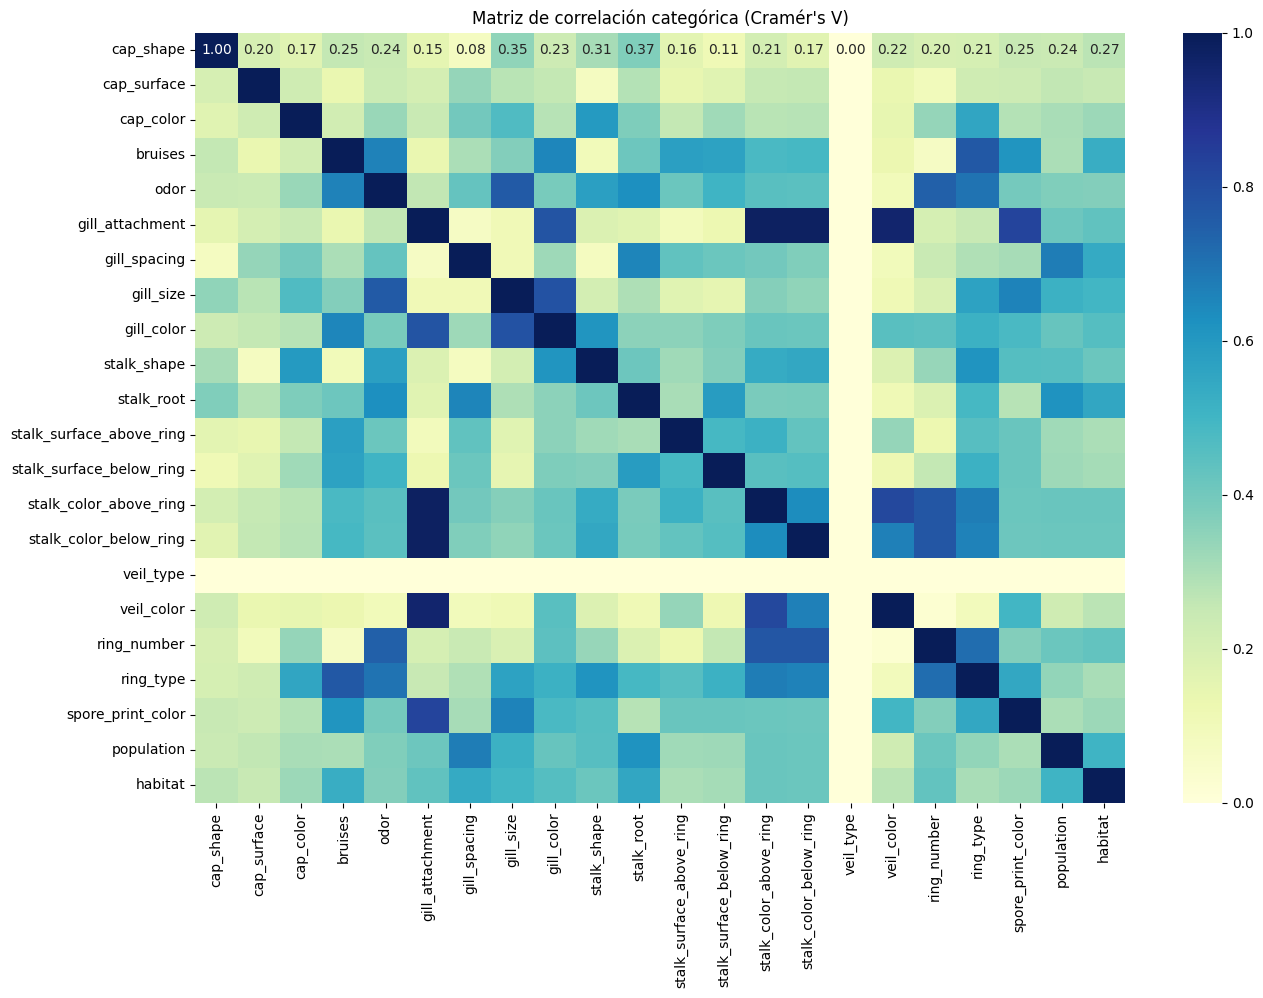

In [9]:
#Mediante la funcion de Cramér's V se calcula la correlacion entre variables categoricas
def cramers_v(x, y):
    # Eliminar valores NaN para el cálculo
    mask = ~(pd.isna(x) | pd.isna(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Si alguna variable tiene una sola categoría, la correlación es 0
    if len(x_clean.unique()) <= 1 or len(y_clean.unique()) <= 1:
        return 0.0
    
    confusion_matrix = pd.crosstab(x_clean, y_clean)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    
    # Si n es muy pequeño, retornar 0
    if n <= 1:
        return 0.0
        
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    # Evitar división por cero para que no de warning
    denominator = min((kcorr-1), (rcorr-1))
    if denominator <= 0:
        return 0.0
    
    return np.sqrt(phi2corr / denominator)

# Calcular matriz de correlación categórica
cols = [c for c in df.columns if c != 'class']
corr_matrix = pd.DataFrame(index=cols, columns=cols)

for c1 in cols:
    for c2 in cols:
        corr_matrix.loc[c1, c2] = cramers_v(df[c1], df[c2])

corr_matrix = corr_matrix.astype(float)
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Matriz de correlación categórica (Cramér's V)")
plt.show()

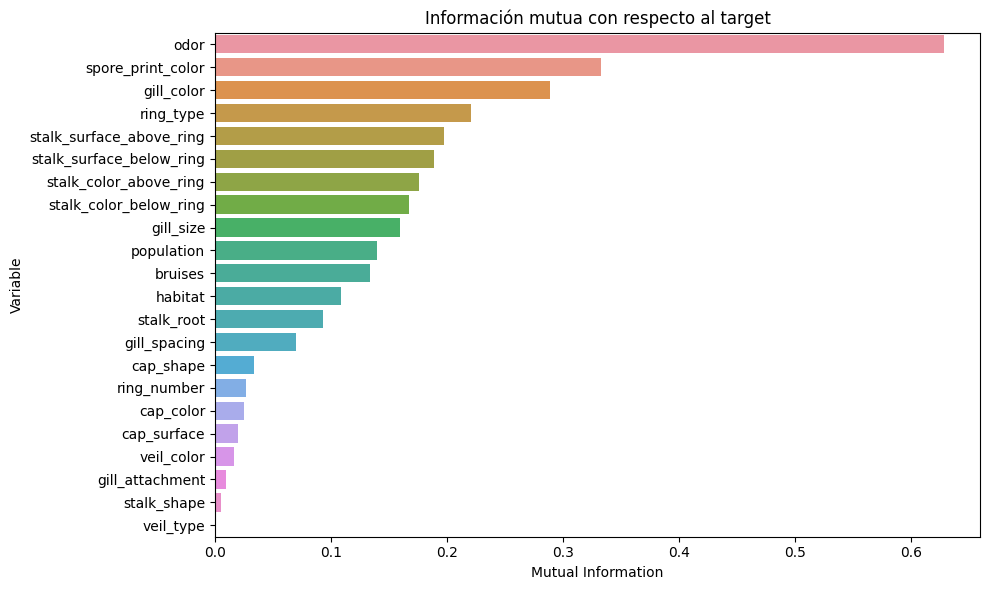

In [10]:
X = df.drop(columns='class')
y = df['class']

# Codificar variables categóricas para obtener información mutua con respecto al target
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, 
                     encoded_missing_value=-2)
X_enc = enc.fit_transform(X)

mutual_info = mutual_info_classif(X_enc, y, discrete_features=True)

mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=mutual_info_series, y=mutual_info_series.index)
plt.title('Información mutua con respecto al target')
plt.xlabel('Mutual Information')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [11]:
X = df.drop(columns='class')
y = df['class']

# Dividir el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1408
)

In [12]:
#Codificación de variables categóricas por one-hot encoding.
#Ventajas: Interpretable, no introduce orden en categorias nominales.
#Desventajas: Aumenta la dimensionalidad del dataset, no maneja bien variables con muchas categorias.

categorical_features = X_train.columns.tolist()

cat_pipeline_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline_ohe, categorical_features)
    ]
)

In [13]:
#Codificación de variables categóricas por target encoding
#Ventajas: No aumenta la dimensionalidad del dataset, maneja variables con muchas categorias
#Desventajas: Puede introducir leakage si no se maneja correctamente, no es interpretable

cat_pipeline_targetencoding = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ce.TargetEncoder(handle_missing='most_frequent', handle_unknown='value'))
])

preprocessor_te = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline_targetencoding, categorical_features)
    ]
)

In [14]:
#Modelo de regresion logistica con preprocesamiento one-hot encoding
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),   # o preprocessor_te
    ('classifier', LogisticRegression(max_iter=20))
])

model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [15]:
#Estructura de pipelines para comparar modelos. 
pipelines = {
    'OneHot + LogisticRegression': Pipeline([
        ('preprocessor', preprocessor_ohe),
        ('model', LogisticRegression(max_iter=100))
    ]),
    'TargetEnc + LogisticRegression': Pipeline([
        ('preprocessor', preprocessor_te),
        ('model', LogisticRegression(max_iter=100))
    ])
}

In [16]:
#Evaluar modelos con cross-validation
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    print(f"{name}: media F1_macro = {scores.mean():.4f} (+/- {scores.std():.4f})")

OneHot + LogisticRegression: media F1_macro = 0.9995 (+/- 0.0009)
TargetEnc + LogisticRegression: media F1_macro = 0.9955 (+/- 0.0012)
TargetEnc + LogisticRegression: media F1_macro = 0.9955 (+/- 0.0012)
